# Pupil Plate Playground

This is an experimental area for Pupil Plate Analysis. Nothing in this notebook should be considered production ready and everything in this notebook should be considered as an unverified, uncontrolled experiment.

The fact that this is checked into a repository and under version control implies nothing with respect to it's stability or suitability for any purpose. Please consider yourself warned.


In [1]:
from astropy.stats import median_absolute_deviation
from astropy.io import fits

import numpy as np
import numpy.ma as ma
import sep
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams

In [2]:
%matplotlib inline

rcParams['figure.figsize'] = [20., 16.]

## Find some fits.fz Files and get and Header Data Unit (hdu)

In [103]:
import glob
import os
import tempfile

fits_list = glob.glob('/home/llindstrom/dev/non-repo/pupe-pat-data/test-fixture/skinny-pupil/input/*')
#fits_list = glob.glob('/home/llindstrom/dev/non-repo/pupe-pat-data/test-fixture/mixed-result/input/*')
#fits_list = glob.glob('/home/llindstrom/dev/non-repo/pupe-pat-data/test-fixture/good-result/input/*')
for i, name in enumerate(fits_list):
    print('{}. {}'.format(i, os.path.basename(name)))

FITS_FILE_INDEX = 3



filepath = fits_list[FITS_FILE_INDEX]
print('current file: {}'.format(os.path.basename(filepath)))

file_basename, file_extension = os.path.splitext(os.path.basename(filepath))

# if we have a .fz file
if file_extension == '.fz':
    temp_dir = tempfile.TemporaryDirectory()
    temp_filename = os.path.join(temp_dir.name, os.path.basename(file_basename))
    sys_call = 'funpack -O {temp_filename} {filename}'.format(temp_filename=temp_filename, filename=filepath)
    
    if os.system(sys_call) != 0:
        print('unpacking problem: {}'.format(sys_call))
        
    filename = temp_filename
    print('unpacked fz file: {}'.format(filename))
else:
    filename = filepath
    print('not an fz file: {}'.format(filepath))

hdu = fits.open(filename)

0. lsc1m005-fl15-20180301-0245-x91.fits.fz
1. lsc1m005-fl15-20180301-0246-x91.fits.fz
2. lsc1m005-fl15-20180301-0247-x91.fits.fz
3. lsc1m005-fl15-20180301-0248-x91.fits.fz
4. lsc1m005-fl15-20180301-0249-x91.fits.fz
5. lsc1m005-fl15-20180301-0250-x91.fits.fz
6. lsc1m005-fl15-20180301-0251-x91.fits.fz
7. lsc1m005-fl15-20180301-0253-x91.fits.fz
current file: lsc1m005-fl15-20180301-0248-x91.fits.fz
unpacked fz file: /tmp/tmp1bmqg8gx/lsc1m005-fl15-20180301-0248-x91.fits


-67.79 < data_e  < 79854.12
mean: 8591.99
std: 1173.48
mad: 68.19
std/mad: 17.21


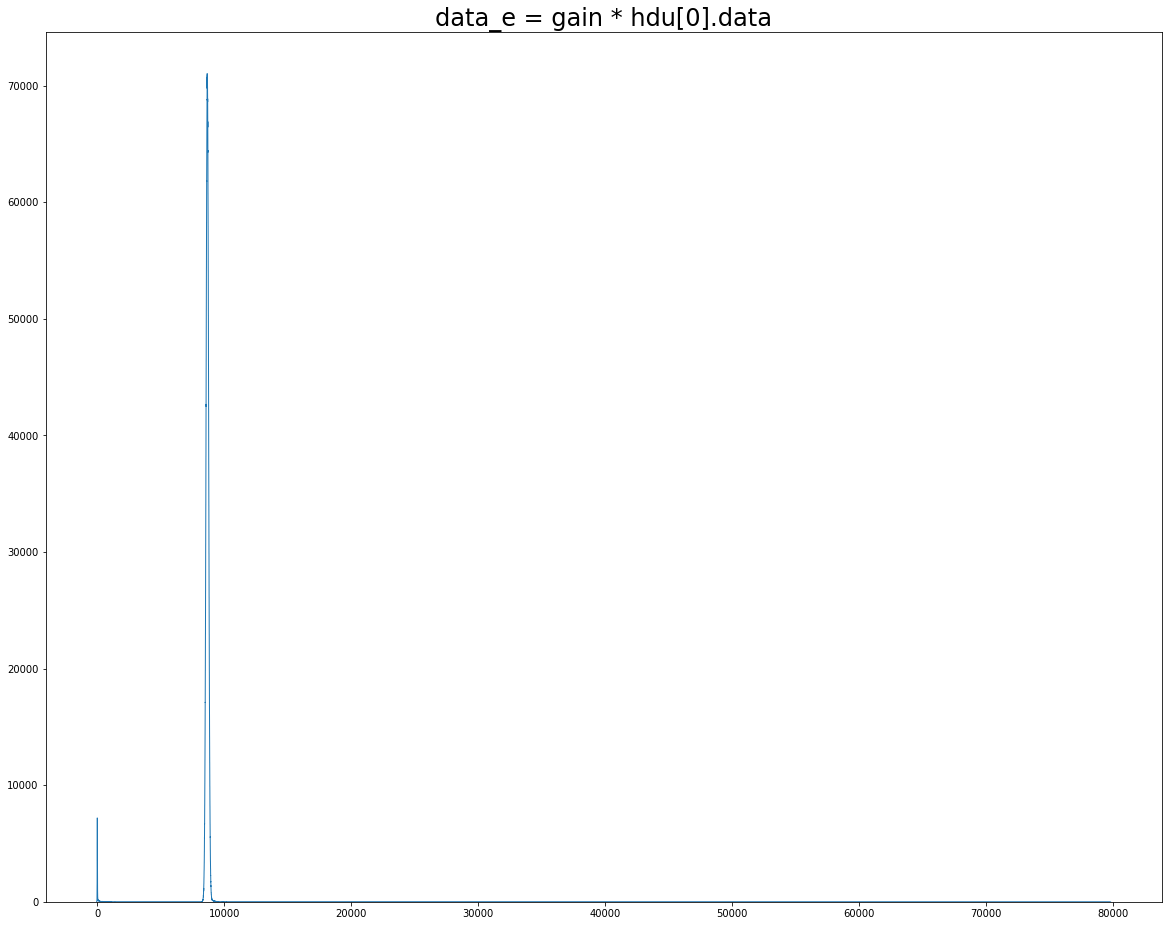

In [104]:
gain = float(hdu[0].header['GAIN']) # e-/count
data_e = gain * hdu[0].data # counts to electrons

mean_data_e = np.mean(data_e)
std_data_e = np.std(data_e)
mad_data_e = median_absolute_deviation(data_e)

print('{:.2f} < data_e  < {:.2f}'.format(data_e.min(), data_e.max()))
print('mean: {:.2f}'.format(mean_data_e))
print('std: {:.2f}'.format(std_data_e))
print('mad: {:.2f}'.format(mad_data_e))
print('std/mad: {:.2f}'.format((std_data_e/mad_data_e)))

plt.title('data_e = gain * hdu[0].data', fontdict={'fontsize': 24})
plt.hist(data_e.ravel(), bins='auto', range=(data_e.min(), data_e.max()),
         histtype='step');

# first, here's what the raw data_e looks like before masking...

7228.24 < 7434.31 < masked_data_e  < 70315.95  < 76779.49
mean: 8697.48
std: 697.18
mad: 67.21
std/mad: 10.37


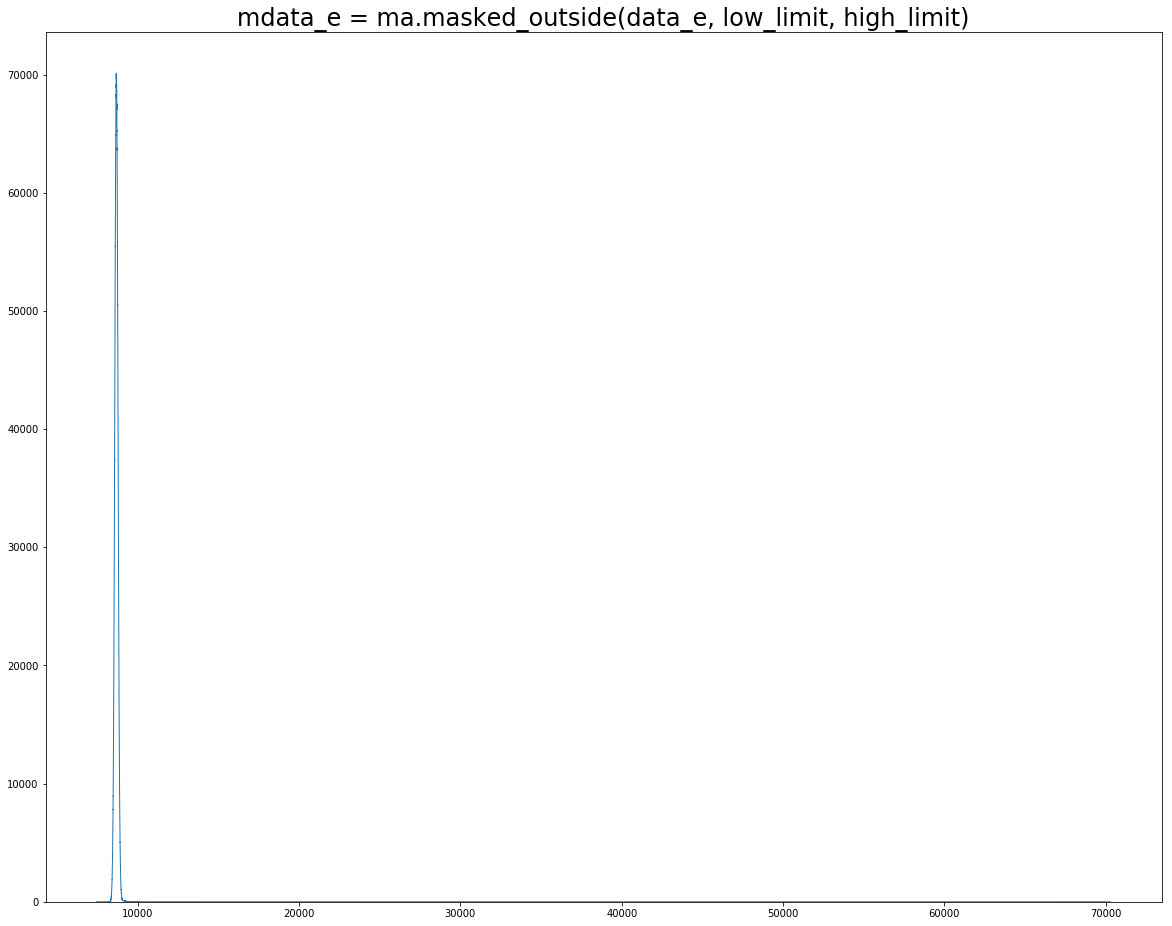

In [105]:
#
# first filter the overscan and any outlier mega pixels
# Do this by masking +/- 10*mad
#
mad_scaling = 20.
low_limit = mean_data_e - mad_scaling * mad_data_e
high_limit = mean_data_e + 50 * mad_scaling * mad_data_e

mdata_e = ma.masked_outside(data_e, low_limit, high_limit)

mean_data_e = ma.mean(mdata_e)
std_data_e = ma.std(mdata_e)
mad_data_e = median_absolute_deviation(mdata_e)

print('{:.2f} < {:.2f} < masked_data_e  < {:.2f}  < {:.2f}'\
      .format(low_limit, mdata_e.min(), mdata_e.max(), high_limit))
print('mean: {:.2f}'.format(mean_data_e))
print('std: {:.2f}'.format(std_data_e))
print('mad: {:.2f}'.format(mad_data_e))
print('std/mad: {:.2f}'.format((std_data_e/mad_data_e)))

plt.title('mdata_e = ma.masked_outside(data_e, low_limit, high_limit)', fontdict={'fontsize': 24})
plt.hist(mdata_e.ravel(), bins='auto', range=(mdata_e.min(), mdata_e.max()),
         histtype='step');


Read Noise: 9.26
Gain: 1.00
Noise: 100.92
Median(data_e): 8677.89
bias_level: -1420.73
Negative bias -1420.73. Scaling data by (sqrt(median)/noise): (0.92/93.16)=100.92
Mean: 7931.12
StdDev: 1083.22


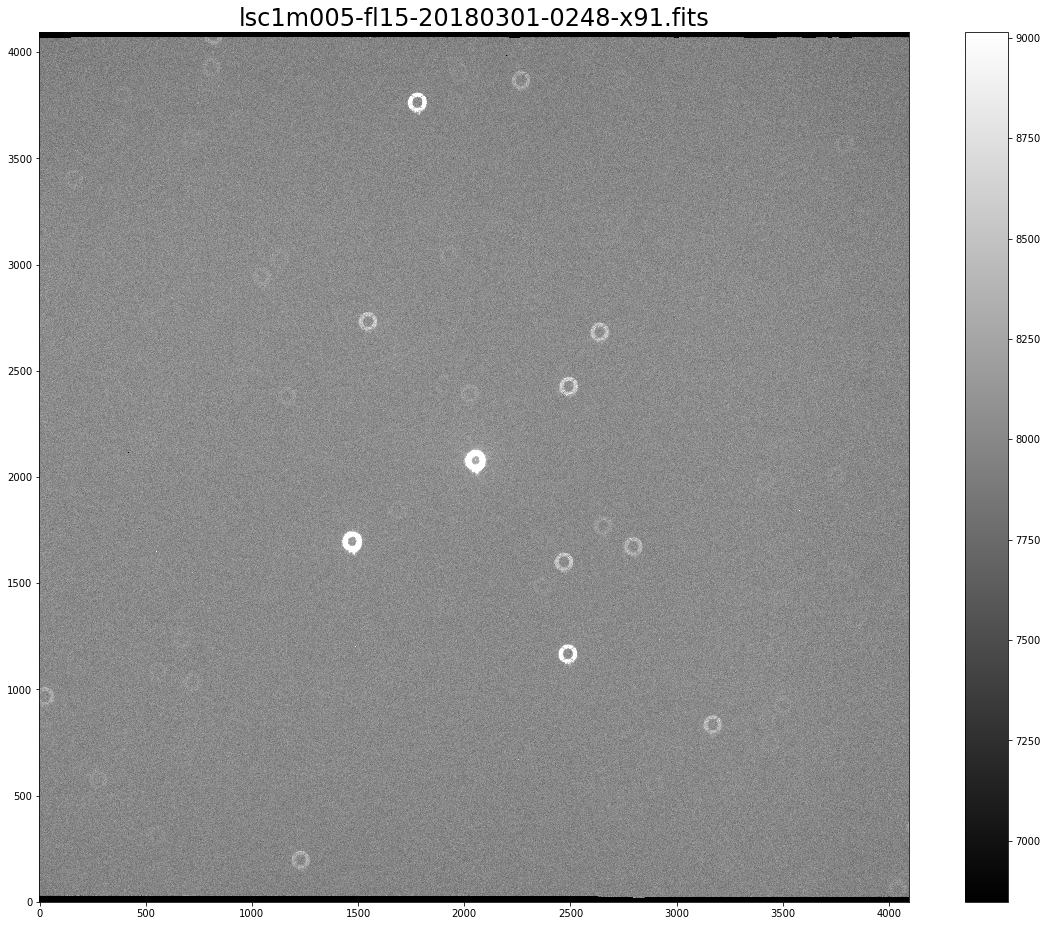

In [106]:
def estimate_bias_level(hdu): #data_e
    """
    Estimate the bias level of image

    Uses median_absolute_deviation (MAD) to compute standard deviation.

    :param hdu: fits hdu with the image in question

    :return: float bias_level
    """
    gain = float(hdu[0].header['GAIN'])            # e-/count
    read_noise_e = float(hdu[0].header['RDNOISE']) # e-/pixel
    data_e = gain * hdu[0].data                    # Counts to electrons
    
    # 1.48 here goes from median absolute deviation to standard deviation
    noise_e = 1.48 * median_absolute_deviation(data_e)
    
    bias_level_in_electrons = np.median(data_e) - noise_e * noise_e + read_noise_e * read_noise_e

    print('Read Noise: {:.2f}'.format(read_noise_e))
    print('Gain: {:.2f}'.format(gain))
    print('Noise: {:.2f}'.format(noise_e))
    print('Median(data_e): {:.2f}'.format(np.median(data_e)))
    print('bias_level: {:.2f}'.format(bias_level_in_electrons))
    return bias_level_in_electrons

estimated_bias_level_in_electrons = estimate_bias_level(hdu)

if estimated_bias_level_in_electrons < 0:
    noise_e = 1.48 * median_absolute_deviation(data_e)
    sqrt_median_e = np.sqrt(np.median(data_e))
    scale_factor = sqrt_median_e / noise_e
    warn = '''Negative bias {:0.2f}. Scaling data by (sqrt(median)/noise): ({:0.2f}/{:0.2f})={:0.2f}'''
    #logger.warning(warn.format(estimated_bias_level_in_electrons, scale_factor, sqrt_median_e, noise_e ))
    print(warn.format(estimated_bias_level_in_electrons, scale_factor, sqrt_median_e, noise_e ))
    data_e *= scale_factor
else:
    # bias corrected data in electrons
    data_e = data_e - estimated_bias_level_in_electrons
    
mean = np.mean(data_e)
std = np.std(data_e)
print('Mean: {:.2f}'.format(mean))
print('StdDev: {:.2f}'.format(std))

plt.title(os.path.basename(filename), fontdict={'fontsize': 24})
plt.imshow(data_e, interpolation='nearest', cmap='gray',
           vmin=mean-std, vmax=mean+std, origin='lower')
plt.colorbar();

-62.58029556274414 < data < 73711.9453125


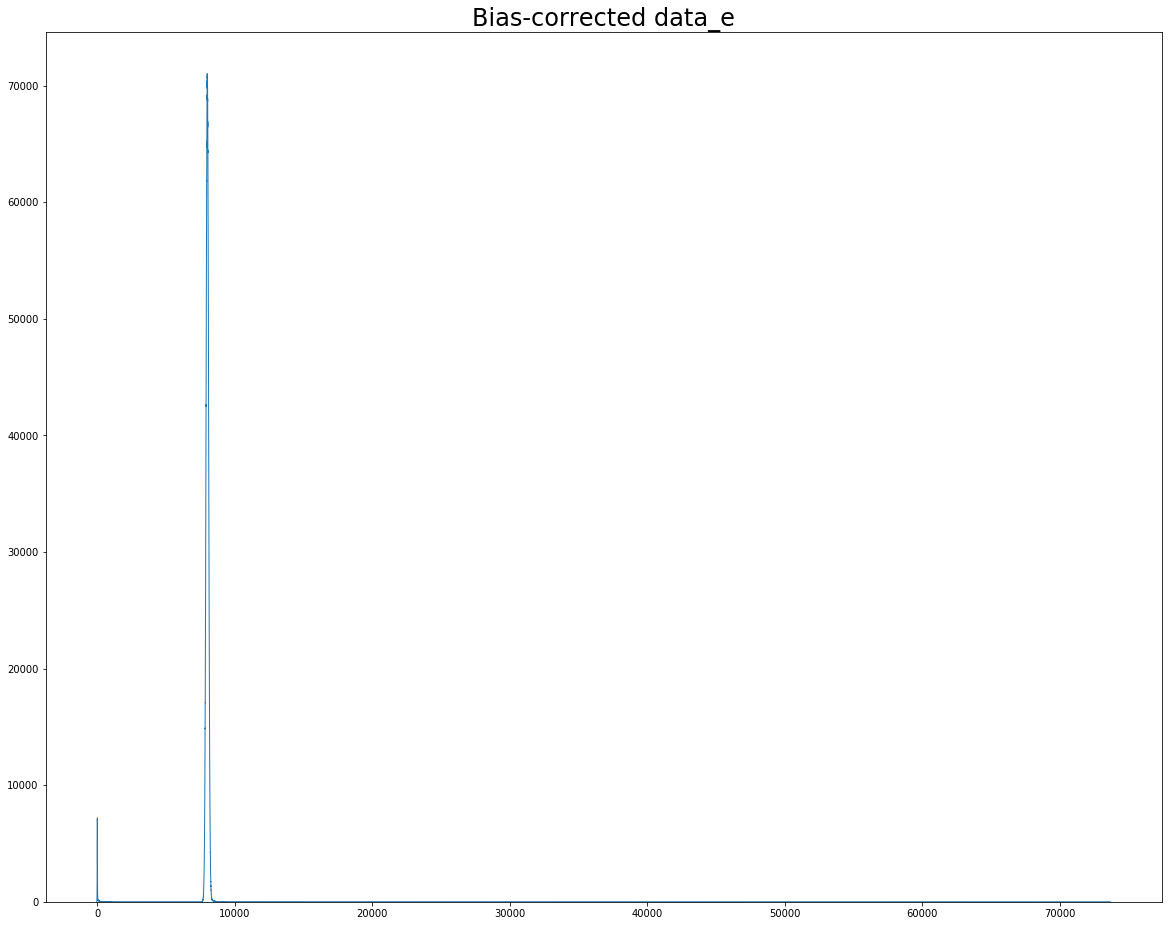

In [107]:
print('{} < data < {}'.format(data_e.min(), data_e.max()))
plt.title('Bias-corrected data_e', fontdict={'fontsize': 24})
plt.hist(data_e.ravel(), bins='auto', range=(data_e.min(), data_e.max()), histtype='step');

Mean: 7931.12
StdDev: 1083.22


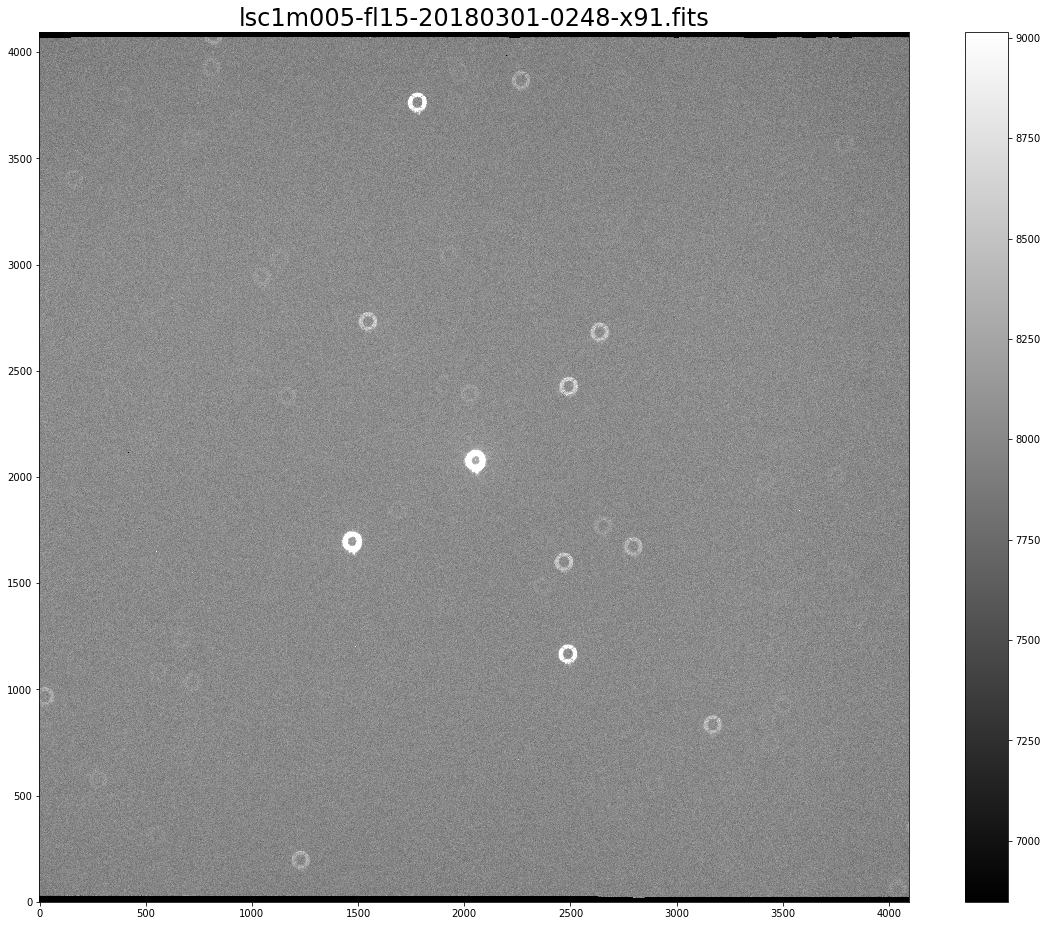

In [108]:
MASK_OVERSCAN_ETAL = False
if MASK_OVERSCAN_ETAL:
    mean_data_e = np.mean(data_e)
    std_data_e = np.std(data_e)
    mad_data_e = median_absolute_deviation(data_e)

    mad_scaling = 20.
    low_limit = mean_data_e - mad_scaling * mad_data_e
    high_limit = mean_data_e + 50 * mad_scaling * mad_data_e
    
    data = ma.masked_outside(data_e, low_limit, high_limit)
else:
    data = data_e # from now on, data is in electrons

    
mean = np.mean(data)
std = np.std(data)
print('Mean: {:.2f}'.format(mean))
print('StdDev: {:.2f}'.format(std))


plt.title(os.path.basename(filename), fontdict={'fontsize': 24})
plt.imshow(data, interpolation='nearest', cmap='gray',
           vmin=mean-std, vmax=mean+std, origin='lower')
plt.colorbar();

-62.58029556274414 < data < 73711.9453125


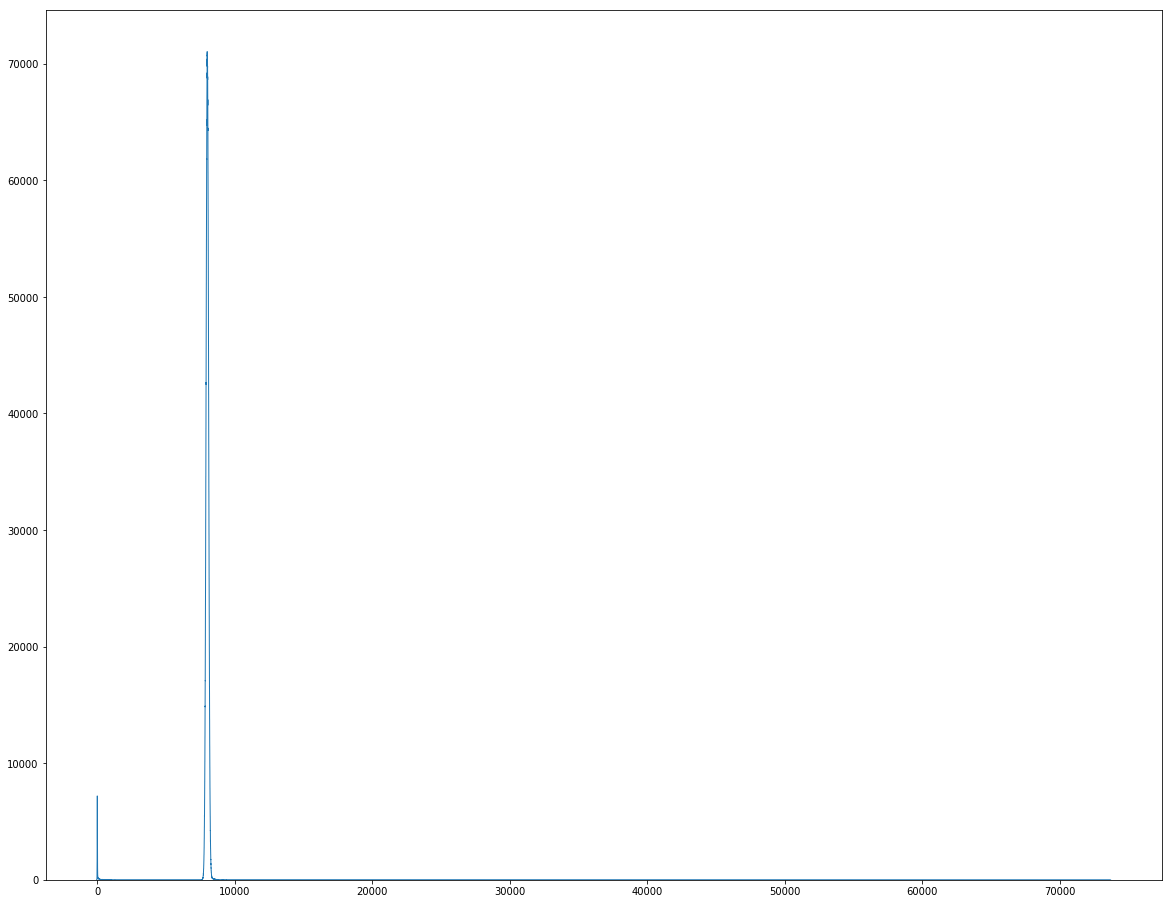

In [109]:
print('{} < data < {}'.format(data.min(), data.max()))
plt.hist(data.ravel(), bins='auto', range=(data.min(), data.max()), histtype='step');

OK. That's the Bias-Level-corrected data (in Electrons).

# Masking and Background Subtraction

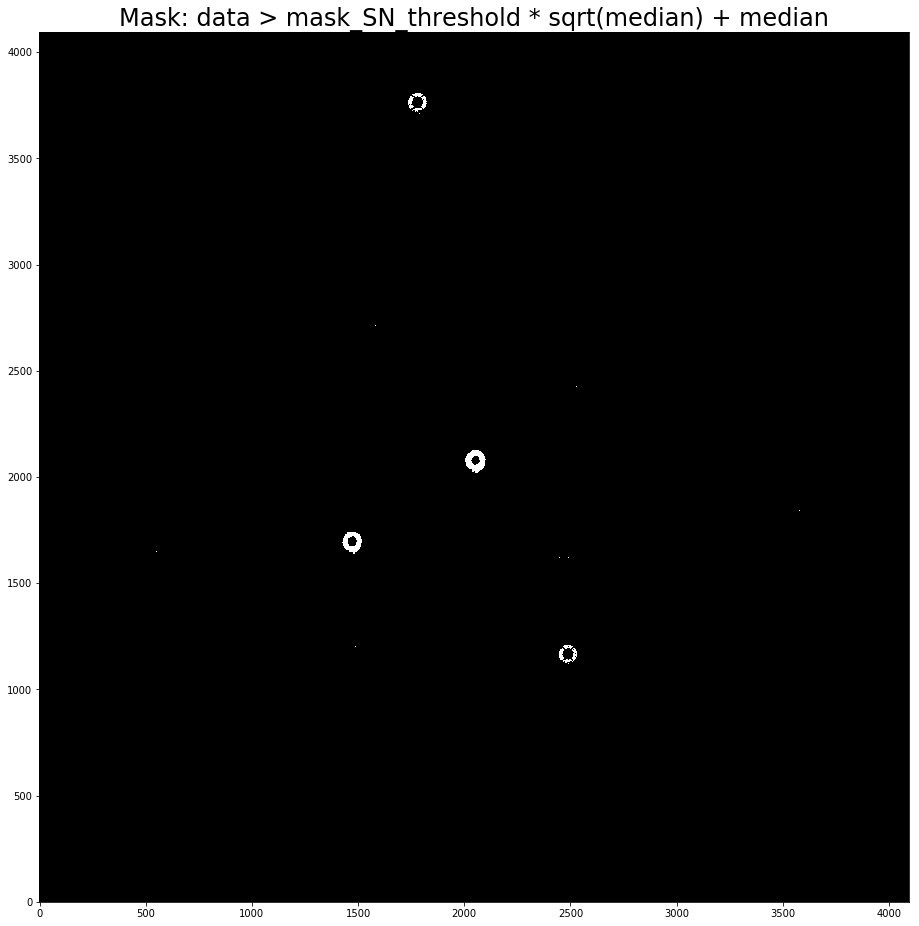

In [110]:
# CONFIG
mask_SN_threshold_scale_factor = 10.0     # initially: 20.0


median = np.median(data) if not MASK_OVERSCAN_ETAL else ma.median(data)
mask_threshold = mask_SN_threshold_scale_factor * np.sqrt(median) + median
mask = np.ascontiguousarray(data > mask_threshold)

plt.title('Mask: data > mask_SN_threshold * sqrt(median) + median', fontdict={'fontsize': 24})
plt.imshow(np.array(mask), interpolation='nearest', cmap='gray', origin='lower');

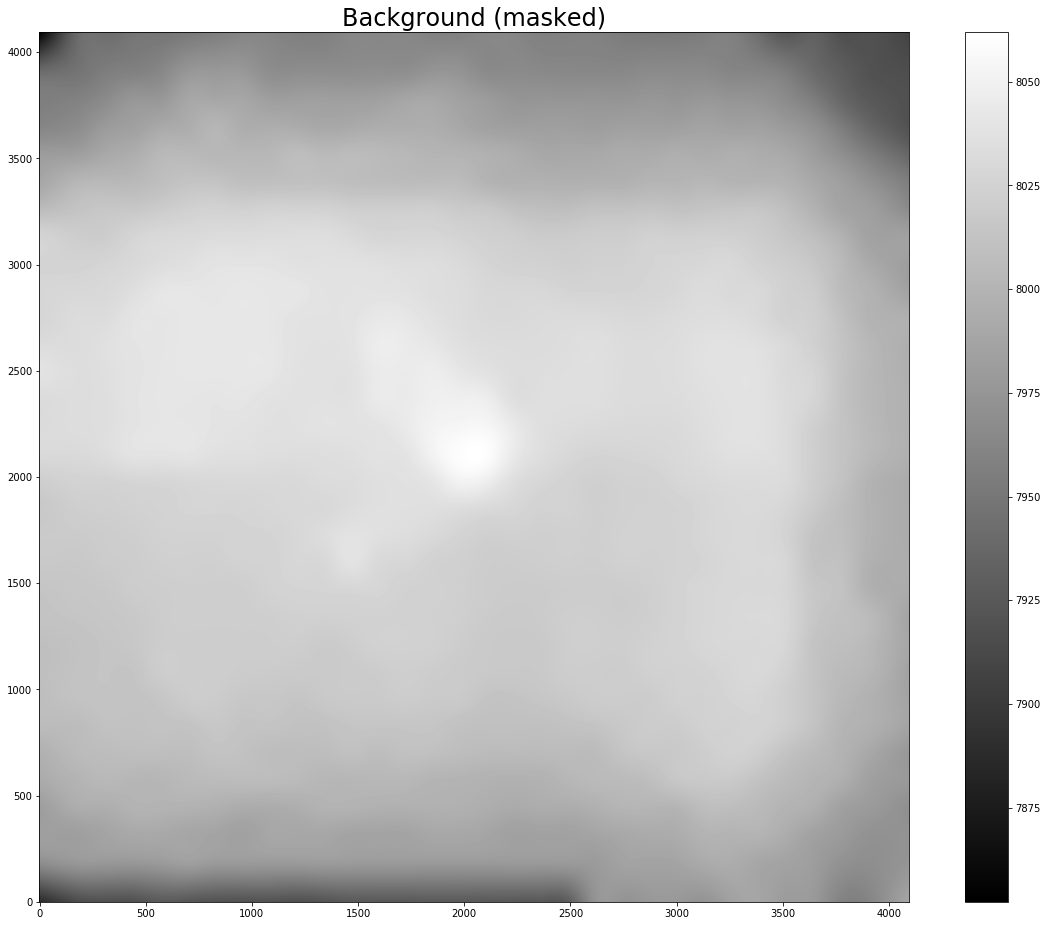

In [111]:
USE_MASK = True
box_size = 128


if USE_MASK:
    plot_title = 'Background (masked)'
    background = sep.Background(np.ascontiguousarray(data),
                                mask=mask,
                                bw=box_size, bh =box_size)
else:
    plot_title = 'Background (not masked)'
    background = sep.Background(np.ascontiguousarray(data))

plt.title(plot_title, fontdict={'fontsize': 24})
bkg_image = np.array(background)
plt.imshow(bkg_image, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();

In [112]:
bgs_data = data - background
bgs_std = np.std(bgs_data) # for use in noise model validation b/c histogram
bgs_mean = np.mean(bgs_data)

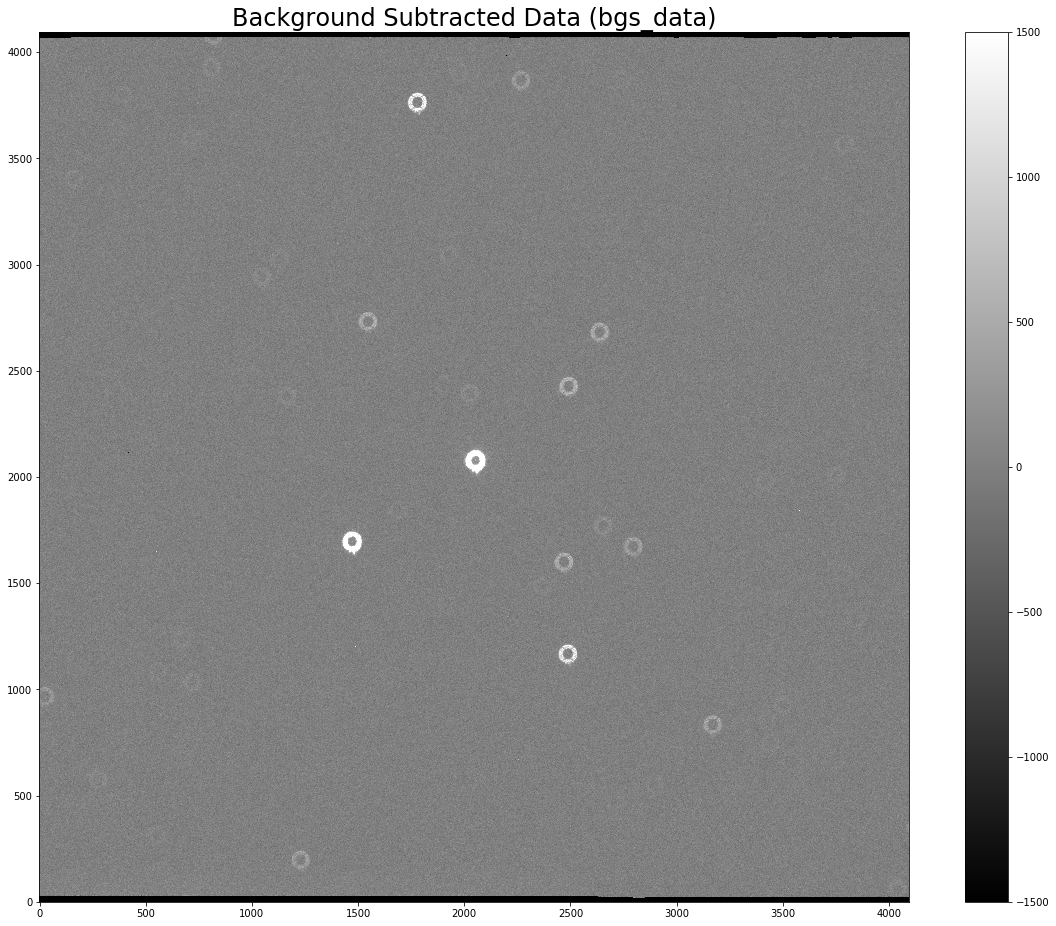

In [113]:
plot_title = 'Background Subtracted Data (bgs_data)'
plt.title(plot_title, fontdict={'fontsize': 24})
bkg_image = np.array(bgs_data)
plt.imshow(bkg_image, interpolation='nearest', cmap='gray', origin='lower', vmin=-1500, vmax=1500)
plt.colorbar();

6 sources found


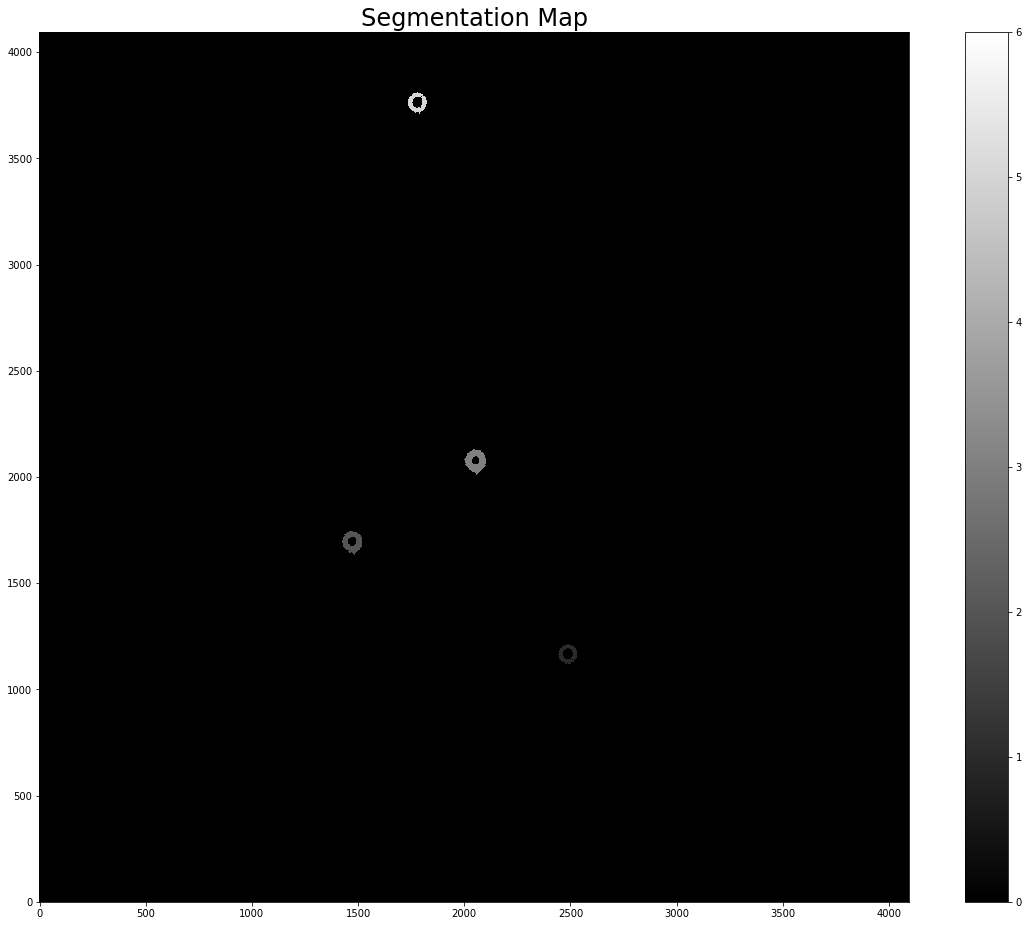

In [114]:
# CONFIG
min_adjacent_pixels = 2000          # initially: 1000  (minarea)
sep_SN_threshold = 5.               # initially: 20.0

read_noise_e = float(hdu[0].header['RDNOISE'])
extract_err = np.sqrt(data + read_noise_e**2.0)

# masking the overscan messes up the segmentation map,
# So, don't do it if MASK_OVERSCAN_ETAL
if MASK_OVERSCAN_ETAL:
    unfiltered_sources = sep.extract(bgs_data, sep_SN_threshold,
                                     err=extract_err,
                                     minarea=min_adjacent_pixels,
                                     deblend_cont=1.0,
                                     filter_kernel=None,
                                     segmentation_map=False)
else:
    unfiltered_sources, seg_map = sep.extract(bgs_data, sep_SN_threshold,
                                              err=extract_err,
                                              minarea=min_adjacent_pixels,
                                              deblend_cont=1.0,
                                              filter_kernel=None,
                                              segmentation_map=True)

print('{} sources found'.format(len(unfiltered_sources)))

if not MASK_OVERSCAN_ETAL:
    plot_title = 'Segmentation Map'
    plt.title(plot_title, fontdict={'fontsize': 24})
    seg_map_image = np.array(seg_map)
    plt.imshow(seg_map_image, interpolation='nearest', cmap='gray', origin='lower')
    plt.colorbar();

In [115]:
# filter the sources according to these parameters
# CONFIG
bad_column_max = 400         # initially: 400
bad_column_min = 200         # initially: 200
in_focus_scale_factor = 200  # initially: 200
cutout_edge_limit = 150      # initially: 150

def source_ok(s):
    # Short circuit if either the source is in focus or if we just picked up a couple of hot columns
    got_bad_columns = (s['xmax'] - s['xmin']) < 200 and (s['ymax'] - s['ymin']) > 400
    got_bad_columns |= (s['xmax'] - s['xmin']) > 400 and (s['ymax'] - s['ymin']) < 200
    
    background = np.median(data)
    in_focus = np.abs(data[int(s['y']), int(s['x'])] - background) > 200.0 * np.sqrt(background)

    edge_limit = cutout_edge_limit
    too_close_to_edge = s['x'] - edge_limit < 0 or s['y'] - edge_limit < 0
    too_close_to_edge |= s['x'] + edge_limit > data.shape[1] or s['y'] + edge_limit > data.shape[0]

    ellipticity_limit = 1.15
    not_a_circle = (max((s['a']/s['b']), (s['a']/s['b'])) > ellipticity_limit)
    
    if got_bad_columns or in_focus or too_close_to_edge or not_a_circle:
        msg = 'Filtered source at ({:0.2f},{:0.2f})'.format(s['x'], s['y'])
        if got_bad_columns:
            error_message = 'Not enough columns.'
        elif in_focus:
            error_message = 'Not a donut.'
        elif too_close_to_edge:
            error_message = 'Too close to the edge.'
        elif not_a_circle:
            error_message = 'Not a circular source.'
        print('{}: {}'.format(msg, error_message))
    else:
        print('Source at ({:0.2f}, {:0.2f}. A, B: ({:0.2f}, {:0.2f})'\
              .format(s['x'], s['y'], s['a'], s['b']))
    
    return not (
        got_bad_columns or
        in_focus or
        too_close_to_edge or
        not_a_circle)

for i,s in enumerate(unfiltered_sources):
    print('Source[{}]: A {:0.2f} B {:0.2f} theta {:0.2f} A/B {:0.2f}'\
          .format(i,s['a'], s['b'], s['theta'], (s['a']/s['b'])))



Source[0]: A 25.38 B 25.31 theta 0.88 A/B 1.00
Source[1]: A 26.09 B 25.24 theta -1.50 A/B 1.03
Source[2]: A 26.19 B 25.41 theta 1.57 A/B 1.03
Source[3]: A 599.99 B 0.29 theta 1.57 A/B 2078.41
Source[4]: A 25.93 B 25.41 theta 0.95 A/B 1.02
Source[5]: A 1000.87 B 0.00 theta 1.57 A/B 428359.84


Source at (2489.82, 1168.05. A, B: (25.38, 25.31)
Source at (1474.59, 1696.19. A, B: (26.09, 25.24)
Source at (2055.11, 2077.51. A, B: (26.19, 25.41)
Filtered source at (0.00,1105.18): Not enough columns.
Source at (1781.35, 3764.19. A, B: (25.93, 25.41)
Filtered source at (4095.00,2023.75): Not enough columns.


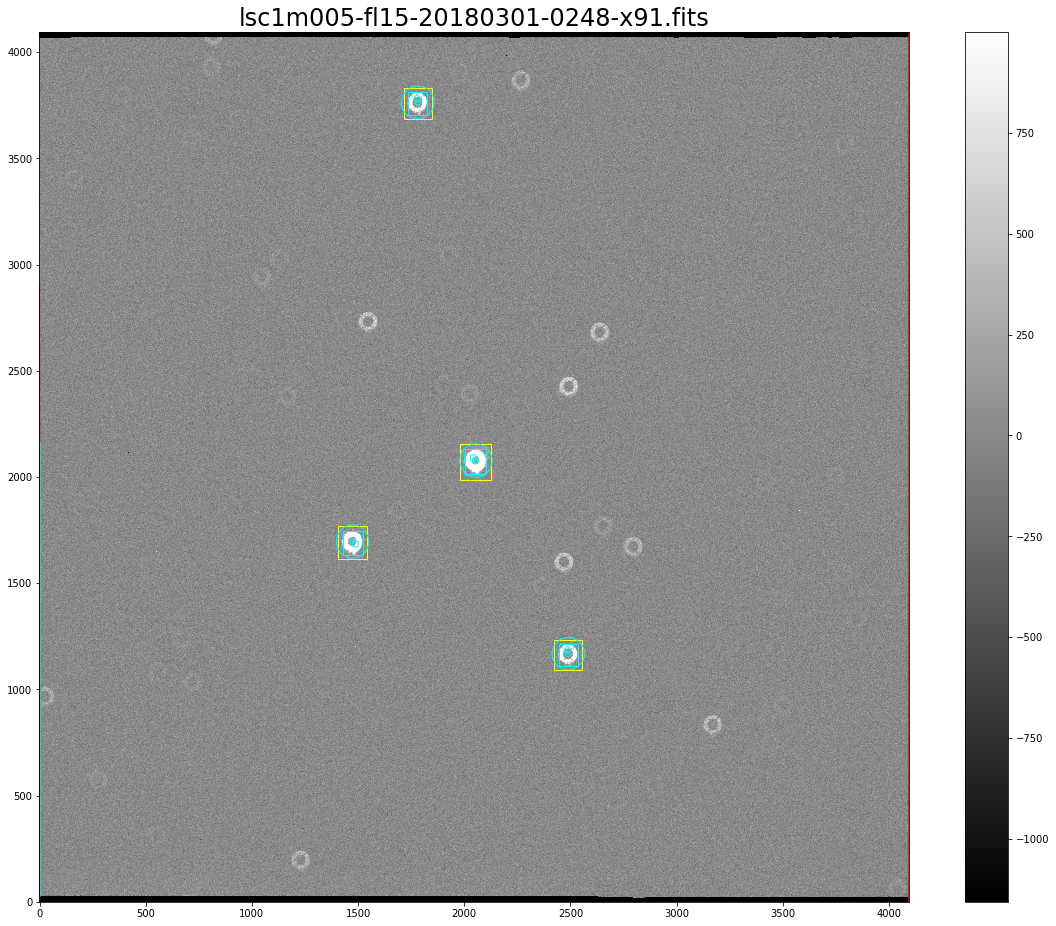

In [116]:
#
# Draw circles around sources (blue= OK; red= not ok).
# Draw the cutouts as yellow rectangles
#
cutout_padding = 0.2 # percent additional margin added to each edge


from matplotlib.patches import Ellipse, Rectangle

# plot background-subtracted image
fig, ax = plt.subplots()
bgs_mean = np.mean(bgs_data)
bgs_std = np.std(bgs_data)

plt.title(os.path.basename(filename), fontdict={'fontsize': 24})
im = plt.imshow(bgs_data, interpolation='nearest', cmap='gray',
               vmin=bgs_mean-bgs_std, vmax=bgs_mean+bgs_std, origin='lower')
plt.colorbar()

# plot an ellipse for each object
sources = []
for i, s in enumerate(unfiltered_sources):
    e = Ellipse(xy=(s['x'], s['y']),
                    width=6*s['a'],
                    height=6*s['b'],
                    angle=s['theta'] * 180. / np.pi)
    e.set_facecolor('none')
    
    ab_rect = Rectangle(xy=(s['x'], s['y']),
                        width=s['a'],
                        height=s['b'],
                        angle=s['theta'] * 180. / np.pi)
    ab_rect.set_facecolor('none')
    ab_rect.set_edgecolor('cyan')
    ax.add_artist(ab_rect)
    
    e2 = Ellipse(xy=(s['x'], s['y']),
                    width=s['a'],
                    height=s['b'],
                    angle=s['theta'] * 180. / np.pi)
    e2.set_facecolor('none')    
    e2.set_edgecolor('cyan')
    ax.add_artist(e2) 
    
    min_max_rect = Rectangle(xy=(s['xmin'], s['ymin']),
                  width=(s['xmax']-s['xmin']),
                  height=(s['ymax']-s['ymin']))
    min_max_rect.set_facecolor('none')
    min_max_rect.set_edgecolor('cyan')
    ax.add_artist(min_max_rect)
    
    # set color and append to sources
    if source_ok(s):
        sources.append(s)
        e.set_edgecolor('cyan')
        
        pad = cutout_padding * max((s['ymax']-s['ymin']), (s['xmax']-s['xmin']))
        r = Rectangle(xy=(s['xmin']-pad, s['ymin']-pad),
                  width=(s['xmax']-s['xmin']) + 2*pad,
                  height=(s['ymax']-s['ymin']) + 2*pad)
        r.set_facecolor('none')
        r.set_edgecolor('yellow')
        ax.add_artist(r)
    else:
        e.set_edgecolor('red')
    ax.add_artist(e)
    
    
    

## END of Pupil Plate SEP Parameter search
(The cells that follow are leftovers from the SEP documentation).

## START of Pupil Plate Cutout


In [117]:
#
# original functions from pupe-pat
#
def make_cutout(data, x0, y0, r):
    '''Slice the data array centered on (x0,y0) from -r to r+1 in both dimensions.
    '''
    return data[int(y0 - r):int(y0 + r + 1), int(x0 - r):int(x0 + r + 1)]

def cutout_coordinates(cutout, x0, y0):
    x, y = np.meshgrid(np.arange(cutout.shape[1]), np.arange(cutout.shape[0]))
    return np.sqrt((x - x0) ** 2.0 + (y - y0) ** 2.0)

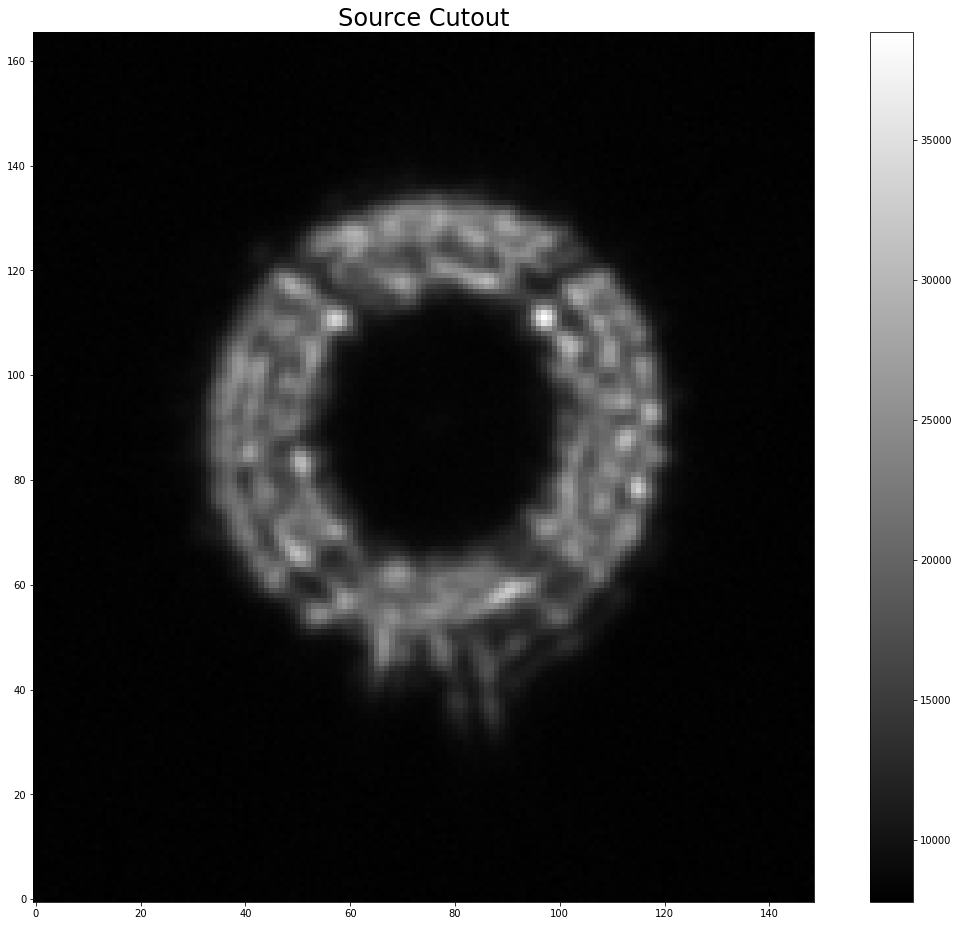

In [118]:
#
# Cutout functions should make use of source properties
#

s = sources[2]
pad = cutout_padding * max((s['ymax']-s['ymin']), (s['xmax']-s['xmin']))
cutout = data[int(s['ymin']-pad):int(s['ymax']+pad), int(s['xmin']-pad):int(s['xmax']+pad)]



plot_title = 'Source Cutout'
plt.title(plot_title, fontdict={'fontsize': 24})
cutout_image = np.array(cutout)
plt.imshow(cutout_image, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();


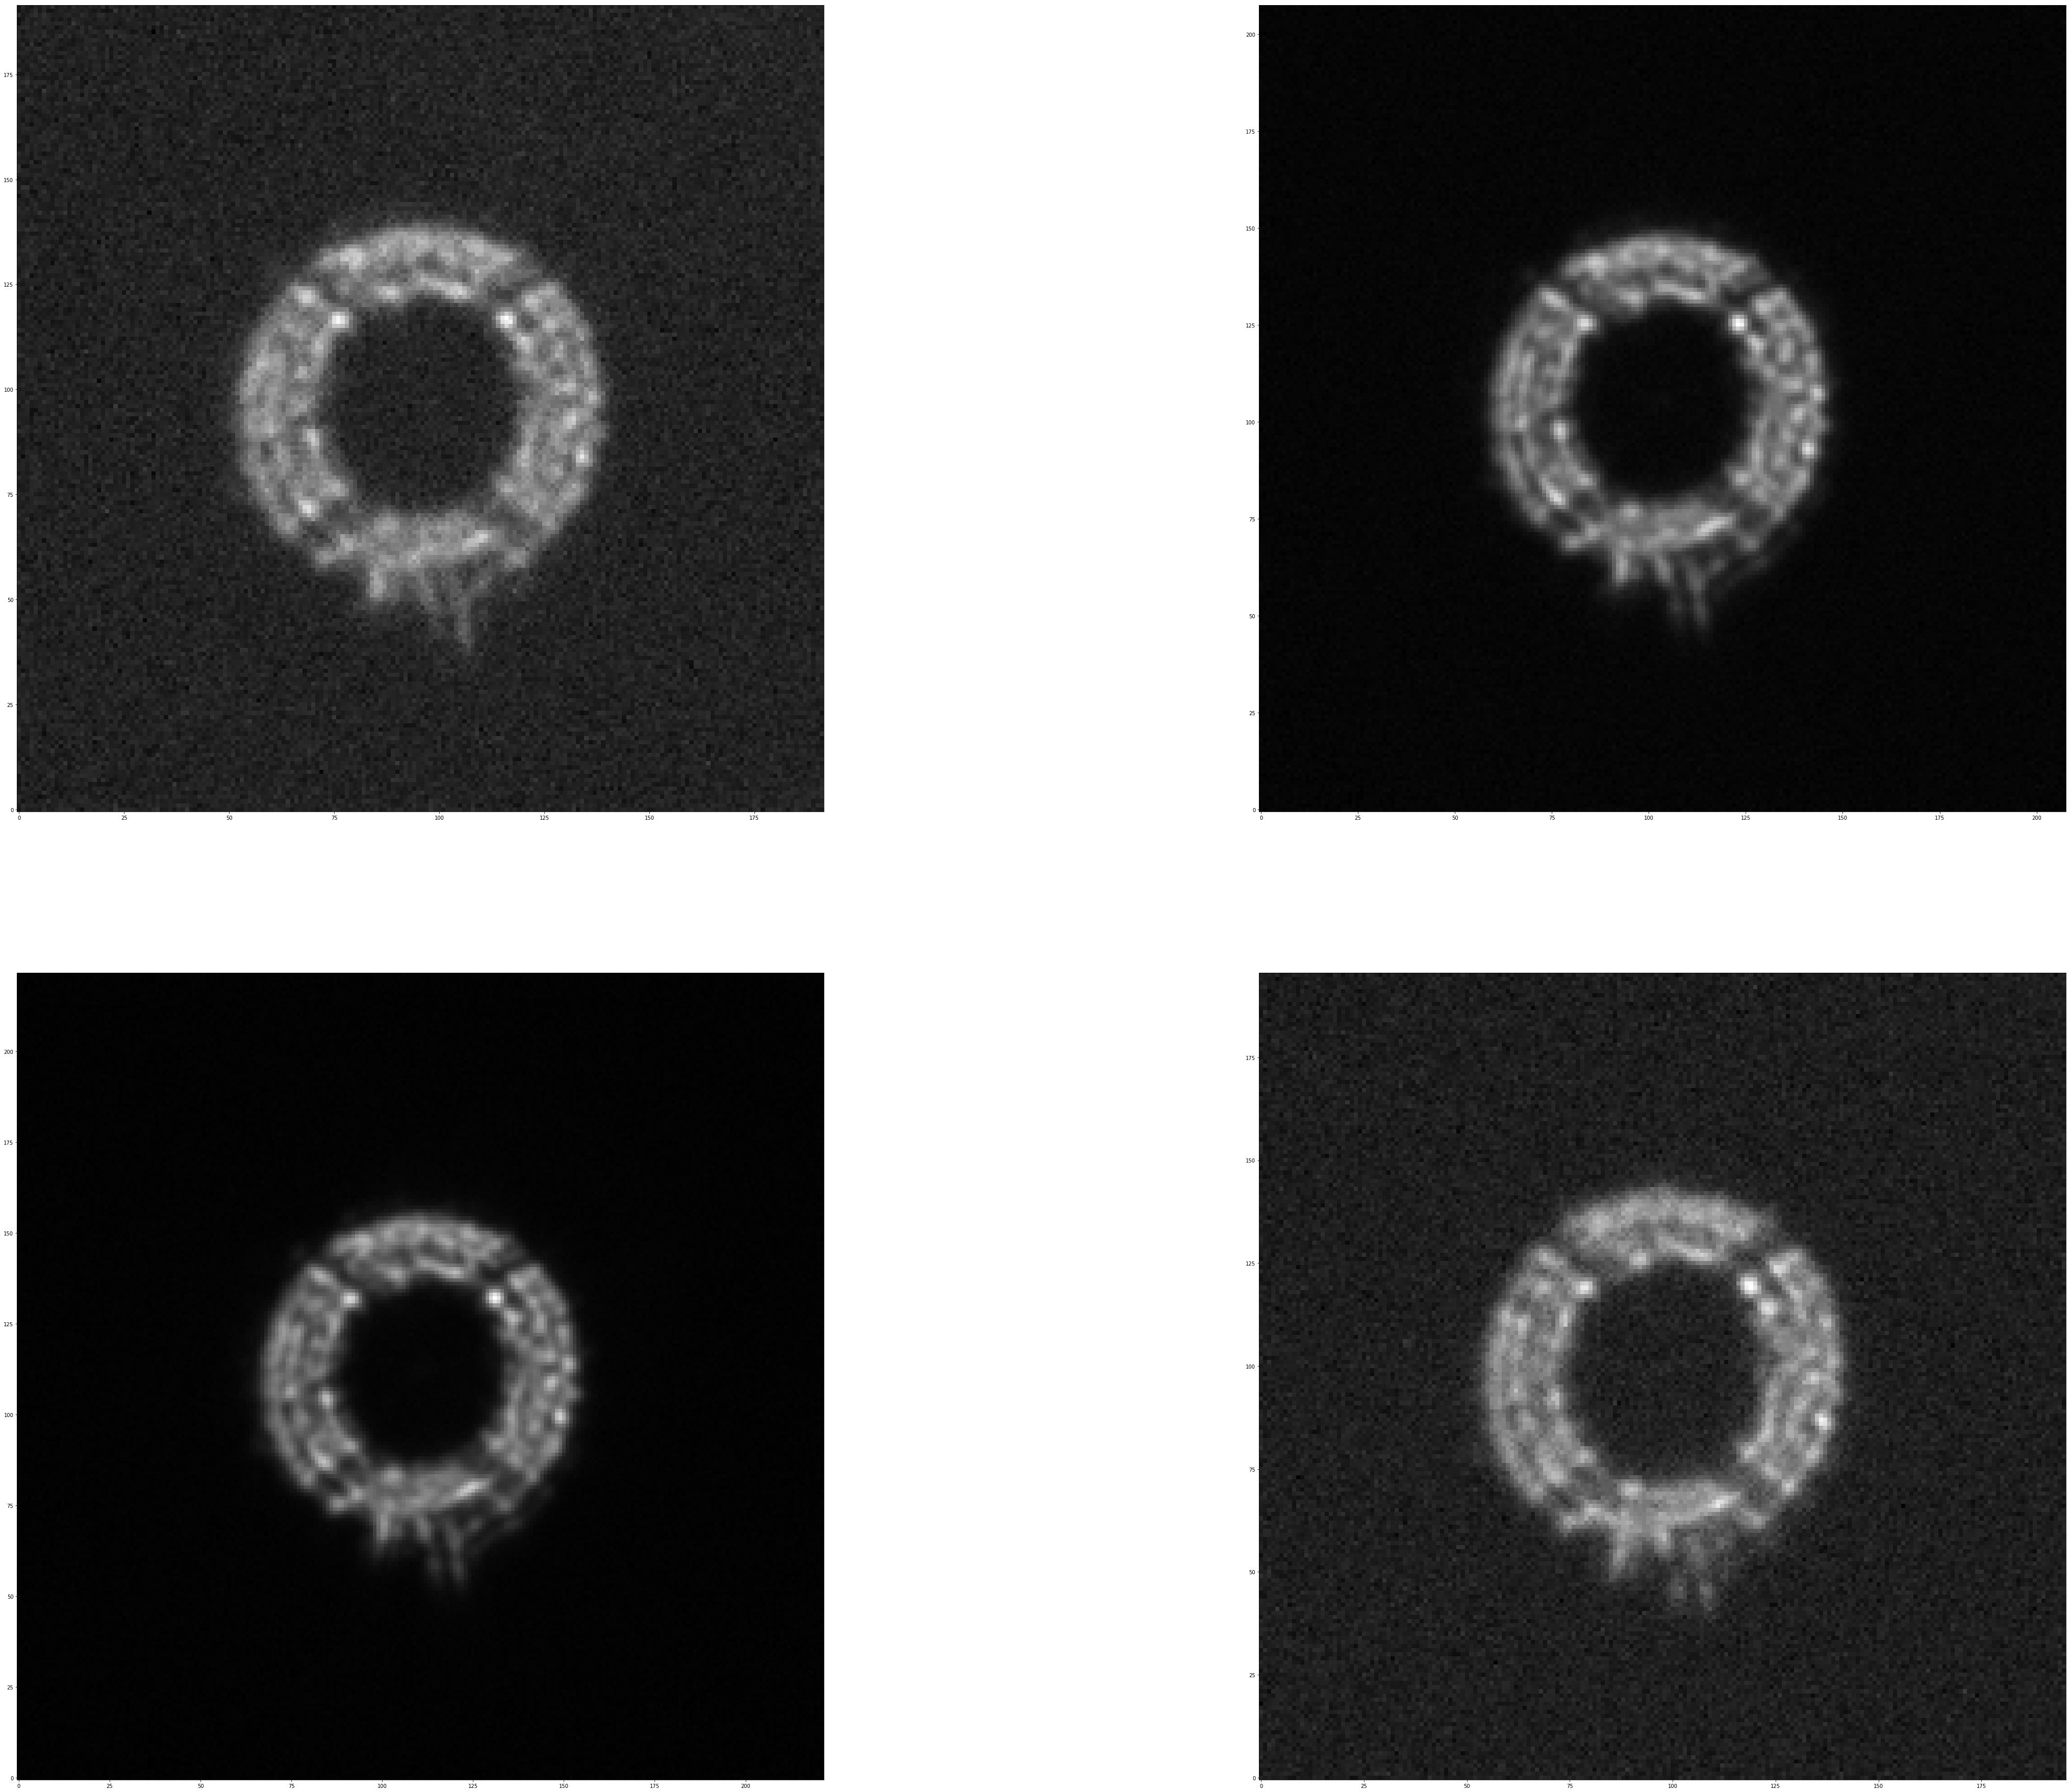

In [141]:
cutouts = []
for s in sources:
    pad = cutout_padding * max((s['ymax']-s['ymin']), (s['xmax']-s['xmin']))
    cutout0 = data[int(s['ymin']-pad):int(s['ymax']+pad),
                   int(s['xmin']-pad):int(s['xmax']+pad)]
    avg_min_max = ((s['ymax']-s['ymin']) + (s['xmax']-s['xmin'])) / 2.0
    cutout = make_cutout(data, s['x'], s['y'], avg_min_max)
    
    cutouts.append(cutout)

columns=2
n_images = len(cutouts)
fig = plt.figure()
for n, (cutout, source) in enumerate(zip(cutouts, sources)):
    a = fig.add_subplot(columns, np.ceil(n_images/float(columns)), n + 1)
    plt.imshow(cutout, interpolation='nearest', cmap='gray', origin='lower')
fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
plt.show()

# END of Cutout
# START of Fitting (finallly)

In [144]:
# This code from fitting.py is for a single source

index = 1
#cutout = np.array(cutouts[index])
cutout = cutouts[index]
source = sources[index]

# rerun SEP.extract on the cutout and get a seg_map this time
# Run sep again and make sure there is only one source in the cutout
extract_err = np.sqrt(cutout + read_noise_e**2.0)
cutout_mask_threshold = mask_threshold_scale_factor * np.sqrt(np.median(cutout)) + np.median(data)
cutout_background = sep.Background(np.ascontiguousarray(cutout),
                                   mask=np.ascontiguousarray(cutout > cutout_mask_threshold))
cutout_sources, seg_map1 = sep.extract(cutout - cutout_background,
                                       sep_SN_threshold,
                                        err=extract_err,
                                        minarea=min_adjacent_pixels,
                                        deblend_cont=1.0,
                                        filter_kernel=None,
                                        segmentation_map=True)
print(cutout_sources[0])

inner_radius_guess = 3.4 * np.abs(hdu[0].header['FOCDMD'])

outer_radius_guess = 3.0 * inner_radius_guess if hdu[0].header['FOCDMD'] > 0 else 2.25 * np.abs(hdu[0].header['FOCDMD'])
outer_radius_guess = 1.618 * inner_radius_guess

print('inner_radius_guess: {:.3f}'.format(inner_radius_guess))
print('outer_radius_guess: {:.3f}'.format(outer_radius_guess))

assert len(cutout_sources) == 1, \
'{} sources detected in cutout. Likely source crowding.'.format(len(cutout_sources))


fig, ax = plt.subplots()
plt.title('Cutout', fontdict={'fontsize': 24})
im = plt.imshow(cutout, interpolation='nearest', cmap='gray',
                origin='lower')
plt.colorbar()


for i, s in enumerate(cutout_sources):
    
    ab_rect = Rectangle(xy=(s['x'], s['y']),
                        width=s['a'],
                        height=s['b'],
                        angle=s['theta'] * 180. / np.pi)
    ab_rect.set_facecolor('none')
    ab_rect.set_edgecolor('cyan')
    ax.add_artist(ab_rect)
    
    e2 = Ellipse(xy=(s['x'], s['y']),
                    width=inner_radius_guess,
                    height=inner_radius_guess,
                    angle=s['theta'] * 180. / np.pi)
    e2.set_facecolor('none')    
    e2.set_edgecolor('green')
    ax.add_artist(e2)
    
    e3 = Ellipse(xy=(s['x'], s['y']),
                    width=outer_radius_guess,
                    height=outer_radius_guess,
                    angle=s['theta'] * 180. / np.pi)
    e3.set_facecolor('none')
    e3.set_edgecolor('green')
    ax.add_artist(e3) 
    
    min_max_rect = Rectangle(xy=(s['xmin'], s['ymin']),
                  width=(s['xmax']-s['xmin']),
                  height=(s['ymax']-s['ymin']))
    min_max_rect.set_facecolor('none')
    min_max_rect.set_edgecolor('yellow')
    ax.add_artist(min_max_rect)
    
    

NameError: name 'mask_threshold_scale_factor' is not defined

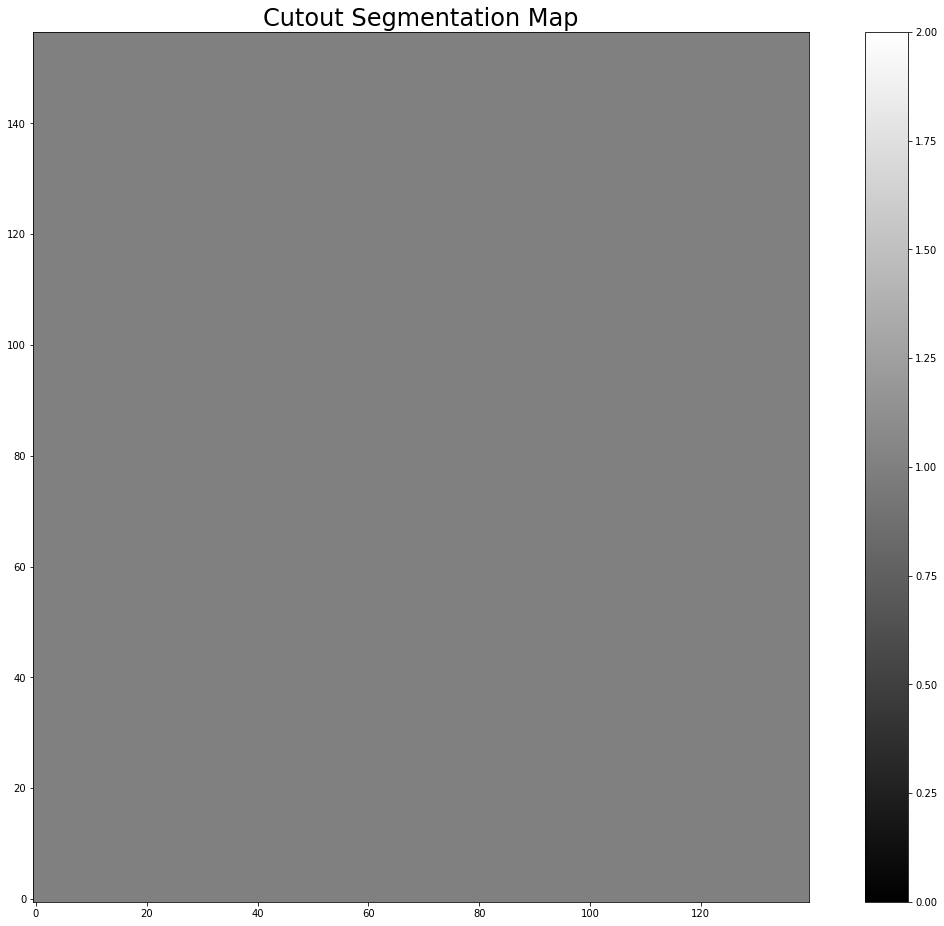

In [139]:
plot_title = 'Cutout Segmentation Map'
plt.title(plot_title, fontdict={'fontsize': 24})
seg_map_image = np.array(seg_map1)
plt.imshow(seg_map_image,
           #interpolation='nearest',
           vmin=0., vmax=2.0,
           cmap='gray', origin='lower')
plt.colorbar();

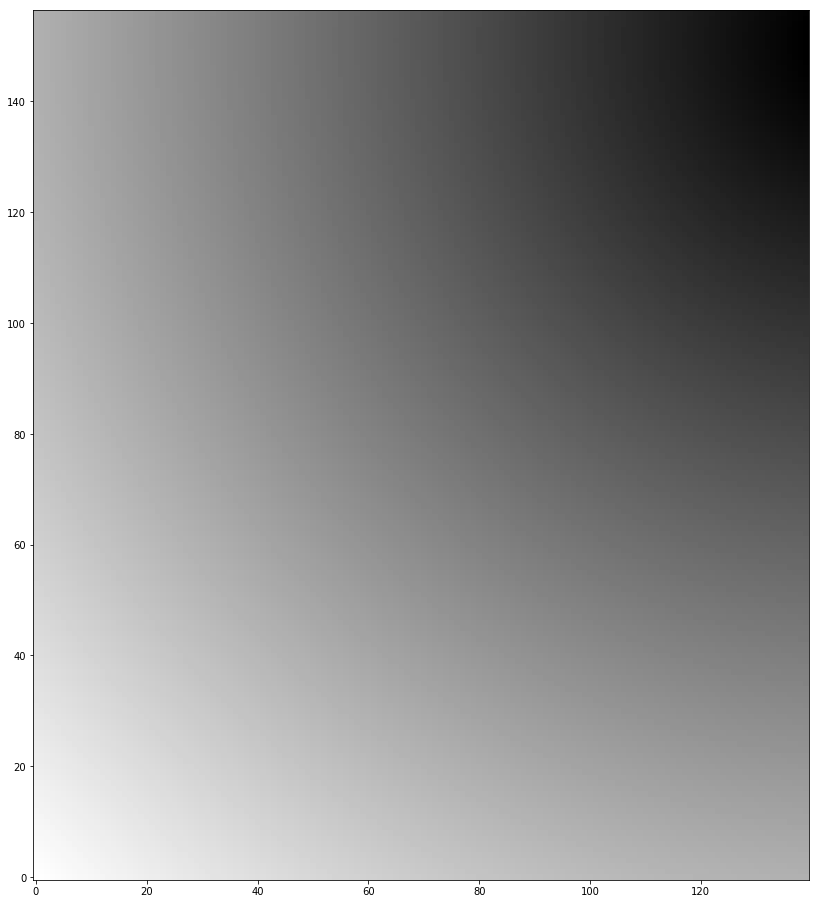

In [140]:
# made it past early exit -- yes, we belong here...
#cutout_radius = config['cutout']['cutout_radius'] # parameterized
cutout_radius = 150 # CONFIG

#cutout = make_cutout(data, source['x'], source['y'], cutout_radius)

# r is a 2-d array of distances from the center of the cutout
r = cutout_coordinates(cutout, cutout_radius + 1, cutout_radius + 1)

plt.imshow(np.array(r),
           interpolation='nearest',
           #vmin=0., vmax=2.0,
           cmap='gray', origin='lower');

amplitude_inner::inner_brightness_guess: nan


/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:4033: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)
/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in greater


IndexError: cannot do a non-empty take from an empty axes.

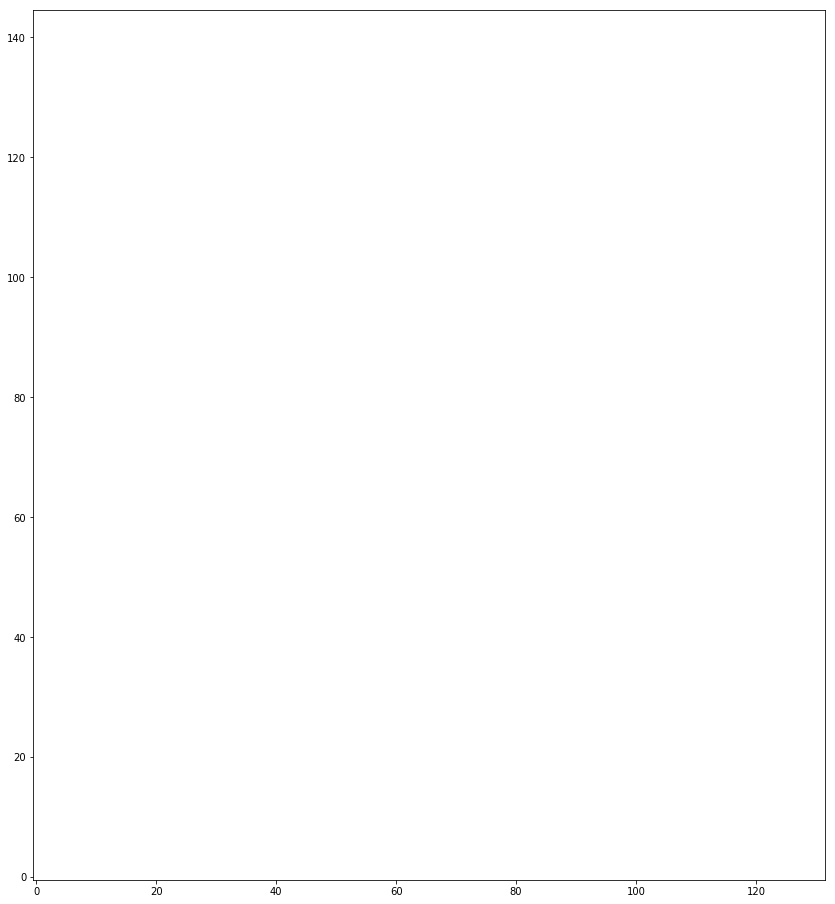

In [131]:
# so, inner_brightness_guess is the median of cutout values with radius 5
inner_brightness_guess = np.median(cutout[r < 5])
print('amplitude_inner::inner_brightness_guess: {:.3f}'.format(inner_brightness_guess))

inside_donut_guess = cutout > (20.0 * np.sqrt(np.median(inner_brightness_guess)) + inner_brightness_guess)
inner_radius_guess = np.percentile(r[inside_donut_guess].flatten(), 5)


# Remake the cutout with +- 4 * inner_radius_guess
cutout_radius = 4.0 * inner_radius_guess
cutout = make_cutout(data, source['x'], source['y'], cutout_radius)
x0 = y0 = cutout_radius + 1.0
r = cutout_coordinates(cutout, x0, y0)



inside_donut_guess = cutout > (20.0 * np.sqrt(np.median(inner_brightness_guess)) + background)
outer_radius_guess = np.percentile(r[inside_donut_guess].flatten(), 90)

brightness_guess = np.median(cutout[np.logical_and(r < outer_radius_guess, r > inner_radius_guess)])
inner_brightness_guess = np.median(cutout[r < inner_radius_guess])



print('inner_radius_guess: {:.3f}'.format(inner_radius_guess))
print('outer_radius_guess: {:.3f}'.format(outer_radius_guess))

print('amplitude_inner::inner_brightness_guess: {:.3f}'.format(inner_brightness_guess))
print('amplitude_outer::brightness_guess: {:.3f}'.format(brightness_guess))
print('backgroup: {:.3f}'.format(np.median(data)))

In [127]:
initial_model = elliptical_annulus(x0_inner=x0, y0_inner=y0,
                                   x0_outer=x0, y0_outer=y0,
                                   amplitude_inner=inner_brightness_guess,
                                   amplitude_outer=brightness_guess,
                                   a_inner=inner_radius_guess,
                                   b_inner=inner_radius_guess,
                                   a_outer=outer_radius_guess,
                                   b_outer=outer_radius_guess,
                                   background=np.median(data))

if not fit_gradient:
    initial_model.x_slope.fixed = True
    initial_model.y_slope.fixed = True

if fit_circle:
    initial_model.theta_inner.fixed = True
    initial_model.theta_outer.fixed = True
    intiial_model.b_inner.tied = lambda x: x.a_inner
    initial_model.b_outer.tied = lambda x: x.a_outer

x, y = np.meshgrid(np.arange(cutout.shape[1]), np.arange(cutout.shape[0]))


fitter = fitting.SimplexLSQFitter()
best_fit_model = fitter(initial_model, x, y, cutout, weights=1.0 / np.abs(cutout), maxiter=20000, acc=1e-6)



#plot_best_fit_ellipse(plot_filename + '_{id}.pdf'.format(id=id), cutout, best_fit_model, header)

#logging_tags = {parameter: getattr(best_fit_model, parameter).value for parameter in best_fit_model.param_names}
#logging_tags['filename'] = image_filename
#for keyword in ['xmin', 'xmax', 'ymin', 'ymax']:
#    logging_tags[keyword] = float(source[keyword])
#
#logger.debug('Best fit parameters for PUPE-PAT model',
#             extra={'tags': logging_tags})
#
#fit_results = {param: getattr(best_fit_model, param).value for param in best_fit_model.param_names}
#fit_results['x0_centroid'], fit_results['y0_centroid'] = x0, y0
#fit_results['sourceid'] = id

/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:4033: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)
/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater
  # This is added back by InteractiveShellApp.init_path()


IndexError: cannot do a non-empty take from an empty axes.

# ATTIC

## Noise Model Validation
The segmentation map below is 0 for pixels not belonging to any source; pixels belonging to source[i] have value i+1.

In [48]:
# Here's how to mask one array with another in numpy...
aa = np.array([1,2,3,4,5,6])
mask = np.array([1, 0, 0, 0, 0, 2])
mm = np.ma.masked_where(mask!=1, aa) # the values of aa where mask is 1

assert 1==np.sum(mm), 'sum: {}'.format(np.sum(mm)) # 1  (sum of values where mask is 1; ie. 1 not masked)
print(np.ma.masked_where(mask!=2, aa)) # [6]

[-- -- -- -- -- 6]


In [49]:
for i in range(len(unfiltered_sources)+1):
    print('Segmentation Map({}) Source[{}]'.format(i, i-1))
    seg_masked_data_std = np.std(np.ma.masked_where(seg_map!=i, data))
    print('seg_masked_data_std: {:.2f}'.format(seg_masked_data_std))

    seg_masked_data_mean = np.mean(np.ma.masked_where(seg_map!=i, data))
    print('seg_masked_data_mean: {:.2f}'.format(seg_masked_data_mean))

    seg_masked_data_median = np.ma.median(np.ma.masked_where(seg_map!=i, data))
    print('seg_masked_data_median: {:.2f}'.format(seg_masked_data_median))

    #from astropy.stats import median_absolute_deviation
    #mad = median_absolute_deviation(np.ma.masked_where(seg_map!=i, data))
    #mad = median_absolute_deviation(data[seg_map_image != i+1])
    #print('robust std: {:0.2f}'.format(1.48 * mad)).
    
    # Validate the background: StdDev(bg) == sqrt(median(bg) + read_noise**2.0)
    read_noise_e = float(hdu[0].header['RDNOISE']) # e-/pixel
    radicand = seg_masked_data_median + read_noise_e**2.0

    print('Background Validation - std: {:0.2f} median: {:0.2f} read_noise: {:0.2f}'\
         .format(seg_masked_data_std, seg_masked_data_median, read_noise_e))
    print('std_dev() == sqrt(median() + read_noise**2.0)')
    print('      {:0.2f} == {:0.2f}'.format(seg_masked_data_std, np.sqrt(radicand)))
    print()

    #assert (abs(bg_std - np.sqrt(radicand))) < 20.0, 'Not small: {:.2f}'.format(abs(bg_std - np.sqrt(radicand)))

Segmentation Map(0) Source[-1]
seg_masked_data_std: 219.63
seg_masked_data_mean: 323.98
seg_masked_data_median: 317.96
Background Validation - std: 219.63 median: 317.96 read_noise: 13.50
std_dev() == sqrt(median() + read_noise**2.0)
      219.63 == 22.37

Segmentation Map(1) Source[0]
seg_masked_data_std: 139.41
seg_masked_data_mean: 499.57
seg_masked_data_median: 487.36
Background Validation - std: 139.41 median: 487.36 read_noise: 13.50
std_dev() == sqrt(median() + read_noise**2.0)
      139.41 == 25.88

Segmentation Map(2) Source[1]
seg_masked_data_std: 199.12
seg_masked_data_mean: 761.59
seg_masked_data_median: 757.56
Background Validation - std: 199.12 median: 757.56 read_noise: 13.50
std_dev() == sqrt(median() + read_noise**2.0)
      199.12 == 30.66

Segmentation Map(3) Source[2]
seg_masked_data_std: 111.00
seg_masked_data_mean: 614.42
seg_masked_data_median: 607.76
Background Validation - std: 111.00 median: 607.76 read_noise: 13.50
std_dev() == sqrt(median() + read_noise**2.0

## Background Subtracted Noise Model Validation

In [50]:
for i in range(len(unfiltered_sources)+1):
    print('Segmentation Map({}) Source[{}]'.format(i, i-1))
    seg_masked_bgs_data_std = np.std(np.ma.masked_where(seg_map!=i, bgs_data))
    print('seg_masked_bgs_data_std: {:.2f}'.format(seg_masked_bgs_data_std))

    seg_masked_bgs_data_mean = np.mean(np.ma.masked_where(seg_map!=i, bgs_data))
    print('seg_masked_bgs_data_mean: {:.2f}'.format(seg_masked_bgs_data_mean))

    seg_masked_bgs_data_median = np.ma.median(np.ma.masked_where(seg_map!=i, bgs_data))
    print('seg_masked_bgs_data_median: {:.2f}'.format(seg_masked_bgs_data_median))

    #from astropy.stats import median_absolute_deviation
    #mad = median_absolute_deviation(np.ma.masked_where(seg_map!=i, data))
    #mad = median_absolute_deviation(data[seg_map_image != i+1])
    #print('robust std: {:0.2f}'.format(1.48 * mad)).
    
    # Validate the background: StdDev(bg) == sqrt(median(bg) + read_noise**2.0)
    read_noise_e = float(hdu[0].header['RDNOISE']) # e-/pixel
    radicand = seg_masked_bgs_data_median + read_noise_e**2.0

    print('Background Validation - std: {:0.2f} median: {:0.2f} read_noise: {:0.2f}'\
         .format(seg_masked_bgs_data_std, seg_masked_bgs_data_median, read_noise_e))
    print('std_dev() == sqrt(median() + read_noise**2.0)')
    print('      {:0.2f} == {:0.2f}'.format(seg_masked_bgs_data_std, np.sqrt(radicand)))
    print()

    #assert (abs(bg_std - np.sqrt(radicand))) < 20.0, 'Not small: {:.2f}'.format(abs(bg_std - np.sqrt(radicand)))

Segmentation Map(0) Source[-1]
seg_masked_bgs_data_std: 218.57
seg_masked_bgs_data_mean: 6.45
seg_masked_bgs_data_median: 1.25
Background Validation - std: 218.57 median: 1.25 read_noise: 13.50
std_dev() == sqrt(median() + read_noise**2.0)
      218.57 == 13.55

Segmentation Map(1) Source[0]
seg_masked_bgs_data_std: 139.44
seg_masked_bgs_data_mean: 207.44
seg_masked_bgs_data_median: 195.58
Background Validation - std: 139.44 median: 195.58 read_noise: 13.50
std_dev() == sqrt(median() + read_noise**2.0)
      139.44 == 19.44

Segmentation Map(2) Source[1]
seg_masked_bgs_data_std: 199.21
seg_masked_bgs_data_mean: 454.01
seg_masked_bgs_data_median: 449.48
Background Validation - std: 199.21 median: 449.48 read_noise: 13.50
std_dev() == sqrt(median() + read_noise**2.0)
      199.21 == 25.13

Segmentation Map(3) Source[2]
seg_masked_bgs_data_std: 111.13
seg_masked_bgs_data_mean: 304.17
seg_masked_bgs_data_median: 298.03
Background Validation - std: 111.13 median: 298.03 read_noise: 13.50
st

# Stuff left over from SEP documentation

Background mean: 5470.89111328125
Background noise: 71.19254302978516


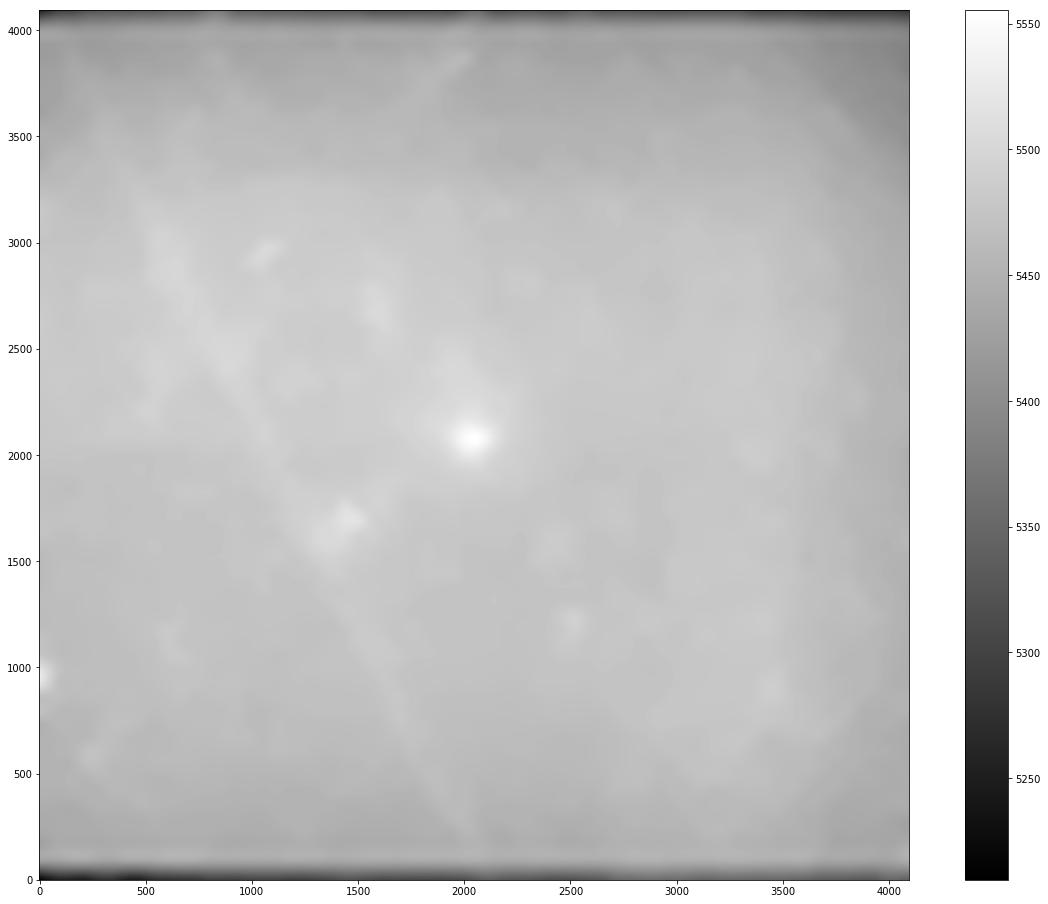

In [18]:
bkg = sep.Background(data)
print('Background mean: {}'.format(bkg.globalback))
print('Background noise: {}'.format(bkg.globalrms))
bkg_image = np.array(bkg)
plt.imshow(bkg_image, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();

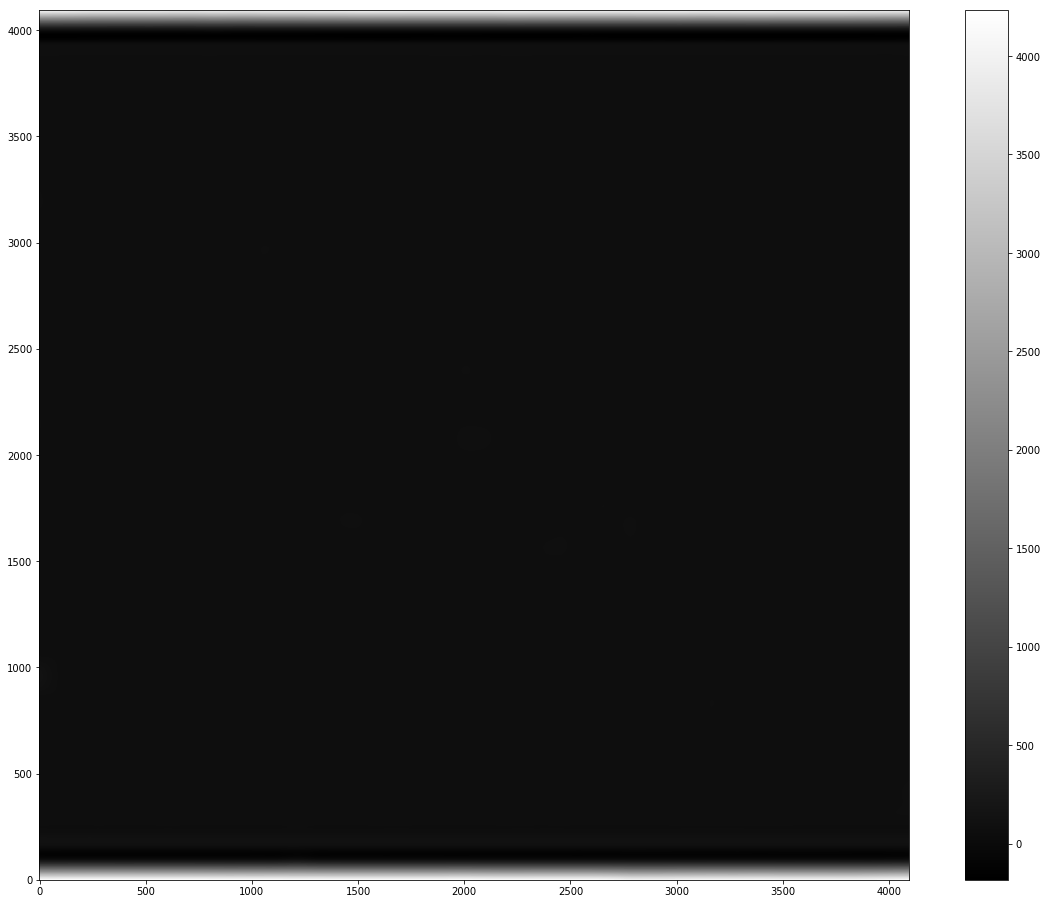

In [19]:
# evaluate the background noise as 2-d array, same size as original image
bkg_rms = bkg.rms()
# show the background noise
plt.imshow(bkg_rms, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();

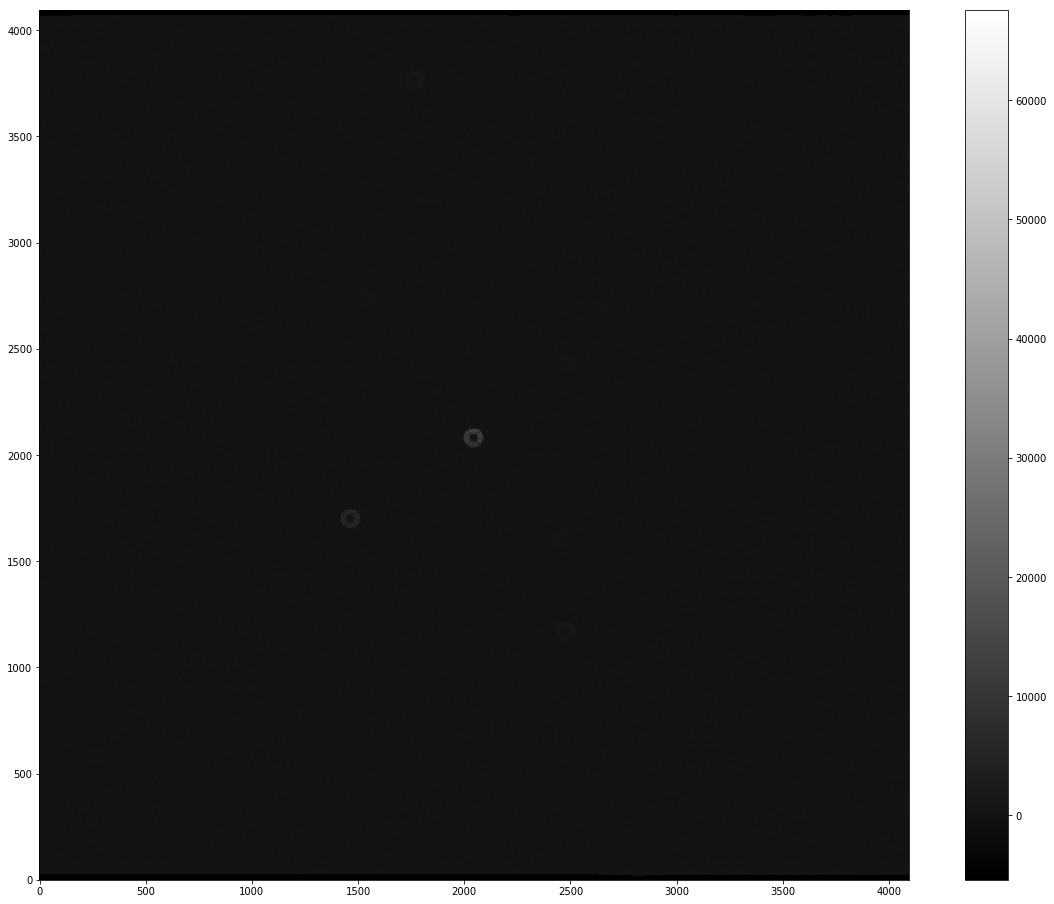

In [20]:
# subtract the background
data_sub = data - bkg
plt.imshow(data_sub, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();

In [21]:
objects = sep.extract(data_sub, 1.5, err=bkg.globalrms)

In [22]:
len(objects)

968